In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 

# FOR REPRODUCIBILITY
np.random.seed(7)

Using TensorFlow backend.


In [2]:
df=pd.read_csv('ABBV Historical Data.csv')
df=df[::-1]
df = df.reset_index()

In [3]:
df.head()

,index,Date,Price,Open,High,Low,Vol.,Change %
0,774,"Sep 13, 2018",96.33,93.42,96.37,93.41,4.85M,3.31%
1,773,"Sep 14, 2018",95.68,96.29,96.40,94.92,3.45M,-0.67%
2,772,"Sep 17, 2018",95.37,95.40,96.16,94.80,3.99M,-0.32%
3,771,"Sep 18, 2018",92.61,95.35,96.06,92.41,10.24M,-2.89%
4,770,"Sep 19, 2018",91.02,91.71,92.24,90.40,8.45M,-1.72%


In [4]:
obs = np.arange(1, len(df) + 1, 1)

In [5]:
OHLC_avg = df[['Price', 'Open', 'High', 'Low']].mean(axis = 1)

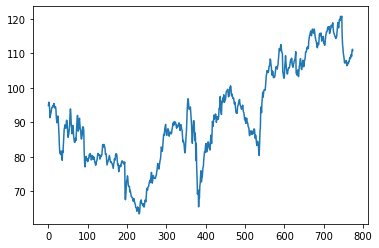

In [6]:
OHLC_avg.plot()

In [7]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [8]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]


In [9]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)


In [10]:
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [12]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
# model.add(Activation('linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
model.compile(loss='mean_squared_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
 - 2s - loss: 0.0196
Epoch 2/5
 - 1s - loss: 9.2832e-04
Epoch 3/5
 - 1s - loss: 8.7390e-04
Epoch 4/5
 - 1s - loss: 7.9210e-04
Epoch 5/5
 - 1s - loss: 7.3253e-04


In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [15]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



In [16]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 1.44
Test RMSE: 1.96


In [17]:
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)


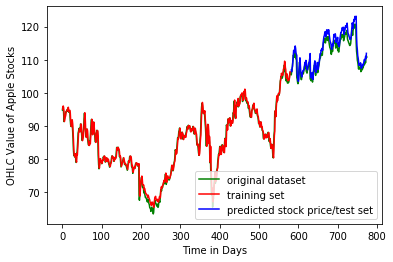

In [18]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'lower right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

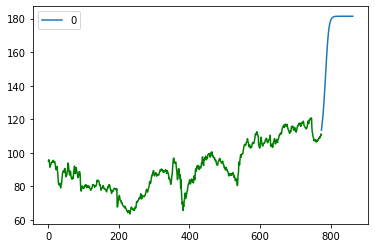

In [19]:
last_val = testPredict[-1]

last_val_scaled = scaler.transform([last_val])
pred=[]
for i in range(90):
    next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
#     print(next_val)
    pred.append(next_val[0])
    last_val_scaled=pred[-1]
# print(pred)
next_val = scaler.inverse_transform(pred)
# print ("Next Day Value:", next_val)

s = range(774,774+90)
next_val = pd.DataFrame(next_val, index=list(s))
next_val.plot()
plt.plot(OHLC_avg, 'g', label = 'original dataset')